# 追記
## 追記1
ete3で可視化時に、例えば下記のように「floatやめろ。intにしろ。」って怒られた場合、
```python
    <略>
    752 ii= QImage(w, h, QImage.Format_ARGB32)
    753 ii.fill(QColor(Qt.white).rgb())
--> 754 ii.setDotsPerMeterX(dpi / 0.0254) # Convert inches to meters
    755 ii.setDotsPerMeterY(dpi / 0.0254)
    756 pp = QPainter(ii)

TypeError: setDotsPerMeterX(self, int): argument 1 has unexpected type 'float'
```
（関連：[issues/635](https://github.com/etetoolkit/ete/issues/635)）  
（関連：[pull/617](https://github.com/etetoolkit/ete/pull/617)）  

エラー解消のために以下のリンクのように修正する。
- https://github.com/etetoolkit/ete/commit/71d0d3b0f0d8e65a93af295a64a4860d2f79551c

と言っても、手動でスクリプトを修正するのも面倒なので[「[Github]ete/ete3/treeview/」](https://github.com/etetoolkit/ete/tree/71d0d3b0f0d8e65a93af295a64a4860d2f79551c/ete3/treeview)に修正された`face.py`と`main.py`と`qt.py`があり、自分はこれをダウンロードして上書きして対処した。  

```
# ダウンロードした後、上書きするコマンドを実行
mv <your path>/faces.py /usr/local/lib/python3.10/site-packages/ete3/treeview --force
mv <your path>/qt.py /usr/local/lib/python3.10/site-packages/ete3/treeview --force
mv <your path>/main.py /usr/local/lib/python3.10/site-packages/ete3/treeview --force
```

## 追記2
BarChartも追加。可視化関数の引数に`node_face_type='bar'`を指定すればBarChartになる。`node_face_type='pie'`でPieChart。

# 環境
DockerのPython環境(Dockerで構築したPython環境だとete3のバグを治すのが面倒だったのでminicondaの方が良いかも)  
###########################  
NAME="Debian GNU/Linux"  
VERSION_ID="12"  
VERSION="12 (bookworm)"  
VERSION_CODENAME=bookworm  
###########################  

Python 3.10.11  
CHAIDの構築、可視化に必要なパッケージと使用したバージョン

- ete3 --'3.1.3'
- CHAID --'5.4.1'
- PyQt5 --'5.15.10'  ete3の内部で使う。
- sklearn2pmml --'0.105.2'  CHAIDのwrapper。sklearnライクに使える。
- svglib --'1.5.1'  svgファイルをpdfファイルやpngファイルに変換するのに使う。
- reportlab --'4.2.0'  svgファイルをpdfファイルやpngファイルに変換するのに使う。
- rlPyCairo --'0.3.0'  svgファイルをpdfファイルやpngファイルに変換するのに使う。
- pykakasi --'2.2.1'  必須ではない。日本語のカラムやカテゴリーを可視化できないのでこれでローマ字に変えたりすると良いかも。

# パッケージインポート

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import japanize_matplotlib

import os
import sys
import ast
import json
import glob
import tqdm as tq
from tqdm import tqdm
import scipy
import gc
import pickle
import datetime as dt
import collections
import time
from dateutil.relativedelta import relativedelta

import sklearn  # ver. '1.4.1.post1'
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.datasets import load_breast_cancer

import string
import re
from collections import OrderedDict
from collections import Counter
import itertools
os.environ['QT_QPA_PLATFORM']='offscreen'  # ete3をJupyterで使うときこれをしないとカーネルが落ちる
sns.set()

In [5]:
# 可視化用パッケージ
import ete3
from ete3 import Tree, TreeStyle, TextFace, PieChartFace, BarChartFace
import PyQt5
import sklearn2pmml
from sklearn2pmml.tree.chaid import CHAIDClassifier
import CHAID
from CHAID import Tree as chaidTree
import svglib
from svglib.svglib import svg2rlg
import reportlab
from reportlab.graphics import renderPDF, renderPM
import rlPyCairo
import pykakasi  # 日本語の可視化ができないのでこれでローマ字に変えたりしましょう

from six import StringIO  # sklearnのCART可視化用
import pydotplus  # sklearnのCART可視化用
from IPython.display import Image  # sklearnのCART可視化用
import dtreeviz  # sklearnのCART可視化用

In [6]:
# # 日本語フォント読み込み
# jpn_fonts=list(np.sort([ttf for ttf in fm.findSystemFonts() if 'ipaexg' in ttf or 'msgothic' in ttf or 'japan' in ttf or 'ipafont' in ttf]))
# jpn_font=jpn_fonts[0]
jpn_font = japanize_matplotlib.get_font_ttf_path()
prop = fm.FontProperties(fname=jpn_font)
print(jpn_font)
# plt.rcParams['font.family'] = prop.get_name() #全体のフォントを設定

/usr/local/lib/python3.10/site-packages/japanize_matplotlib/fonts/ipaexg.ttf


# DATA  
seabornのダイヤモンドの価格データ

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


,cut,color,clarity
count,53940,53940,53940
unique,5,7,8
top,Ideal,G,SI1
freq,21551,11292,13065


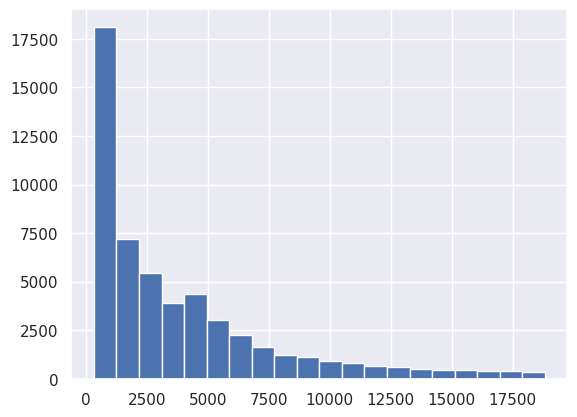

,carat,cut,color,clarity,depth,table,price,x,y,z,target
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43,0
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31,0
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31,0
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63,0
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75,0
...,...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50,0
53936,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61,0
53937,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56,0
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74,0


In [7]:
# Load diamonds dataset from seaborn 
df = sns.load_dataset('diamonds')
display(df.describe())
display(df.describe(include='category'))
plt.hist(df['price'], bins=20)
plt.show()

# priceをカテゴリカルデータへ
df.loc[(df['price']<5000), 'target'] = 0  #'lower_price'
df.loc[(df['price']>=5000)&(df['price']<10000), 'target'] = 1  #'middle_price'
df.loc[(df['price']>=10000), 'target'] = 2  #'upper_price'
df['target'] = df['target'].astype(int)
display(df)

In [8]:
# LabelEncoding
category_cols = df.select_dtypes('category').columns.to_list()
le_list = {}  # ラベルマスタ辞書
dfle = df.copy()
for c in category_cols:
    le = sklearn.preprocessing.LabelEncoder()
    dfle[c] = le.fit_transform(df[c])
    label_tmp = {k:v for k, v in zip(le.transform(le.classes_), le.classes_)}
    le_list[c] = label_tmp
print(le_list)  # ラベルマスタ辞書{<カラム名>:{<ラベル>:<元のカテゴリ>}}

{'cut': {0: 'Fair', 1: 'Good', 2: 'Ideal', 3: 'Premium', 4: 'Very Good'}, 'color': {0: 'D', 1: 'E', 2: 'F', 3: 'G', 4: 'H', 5: 'I', 6: 'J'}, 'clarity': {0: 'I1', 1: 'IF', 2: 'SI1', 3: 'SI2', 4: 'VS1', 5: 'VS2', 6: 'VVS1', 7: 'VVS2'}}


In [9]:
# 説明変数と目的変数
colx = ['cut', 'color', 'clarity', 'carat', 'depth', 'table', 'x', 'y', 'z']
coly = 'target'

# CART  
CARTアルゴリズムの可視化

## 説明変数がすべて連続値の場合

In [10]:
# 学習
df_add = dfle.copy()
clf = DecisionTreeClassifier(min_samples_split=100, max_depth=4, random_state=0)
clf.fit(df_add[colx].to_numpy(), df_add[coly].to_numpy())

DecisionTreeClassifier(max_depth=4, min_samples_split=100, random_state=0)

可視化した図①


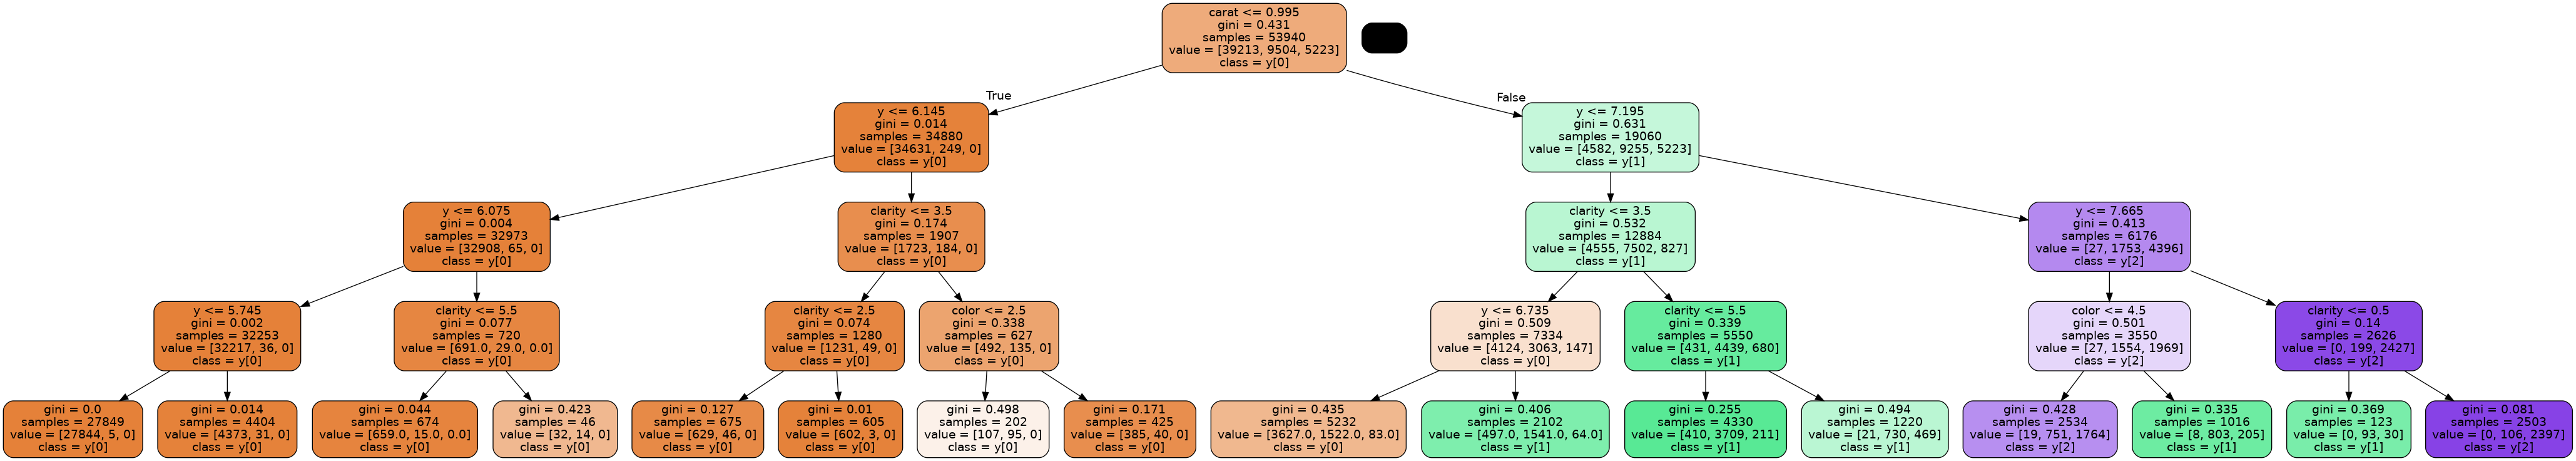

In [11]:
# 決定木の可視化 sklearn標準
dot_data = StringIO()
sklearn.tree.export_graphviz(clf, out_file=dot_data
                             , feature_names=colx
                             , class_names=True
                             , filled=True, rounded=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
print('可視化した図①' )
Image(graph.create_png())

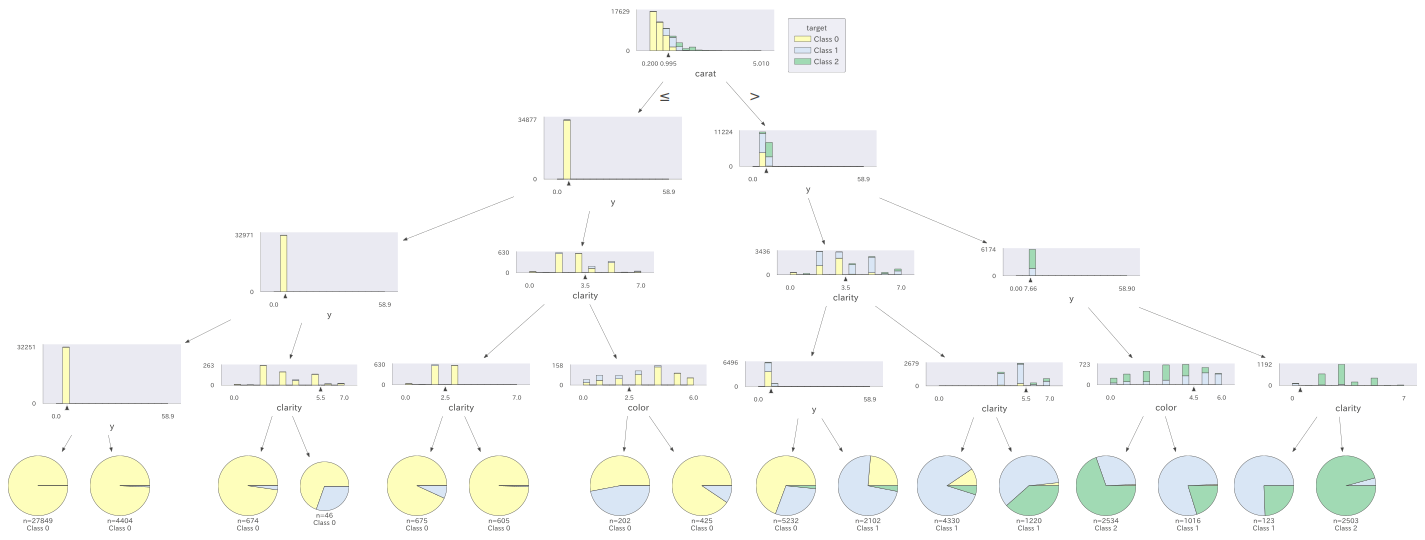

In [12]:
# dtreevizでも可視化
viz = dtreeviz.model(clf#,tree_index=1
                     , X_train=df_add[colx],y_train=df_add[coly]
                     , feature_names=colx
                     , target_name=coly)
viz.view(fontname=prop.get_name())

可視化した図②  
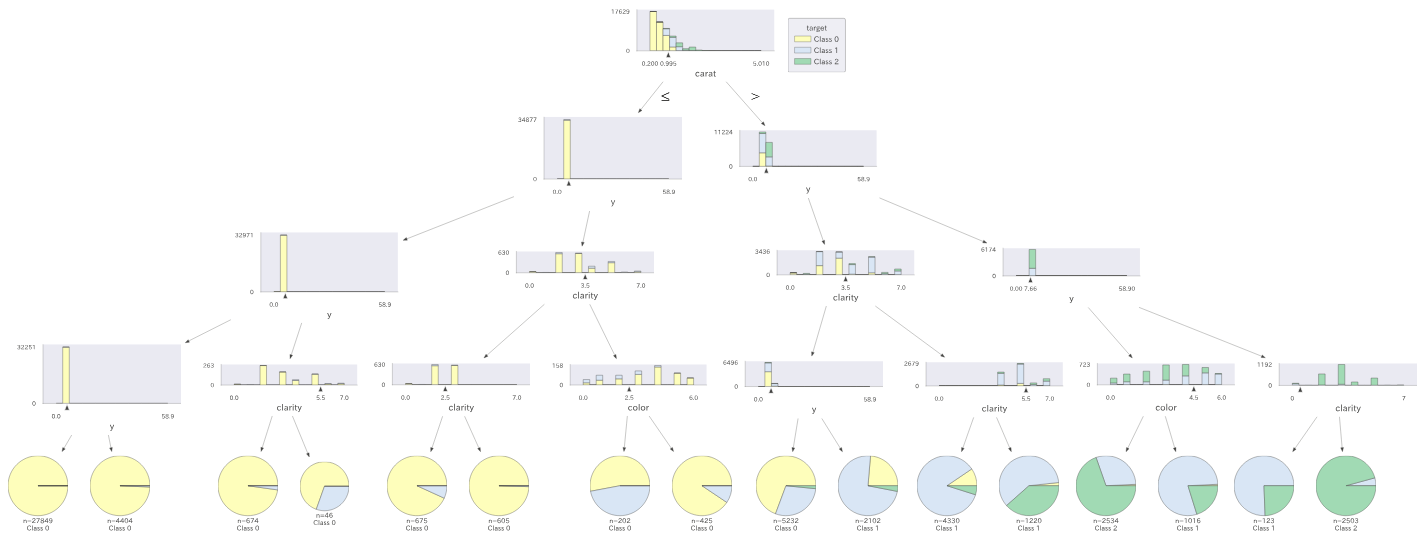

In [13]:
# ete3によるCARTアルゴリズムの可視化関数
def makeTreeEte3CART(clffit, tree_cols, obj_unique, le_list_rename=None, dtype_arr=None, fsize=100, height=300, width=300, diameter=100, rotation=0, node_face_type='pie', name='tmp'):
    # eteのTreeインスタンスを構築
    tree = Tree()
    
    # node size
    # 各ノードのサンプル数の順に木のノードの大きさを変える
    # tree_.n_node_samplesはノードごとのサンプル数を返す
    nodesize={}
    for i, n in enumerate(np.sort(clffit.tree_.n_node_samples)):
        nodesize[n] = i+1
        
    # 各ノードを設定していく
    # tree_.node_countはノード数を返す
    for i in range(clffit.tree_.node_count):
        #i=0、つまりルートノードの名称を0にする
        if i == 0:
            tree.name = str(0)
        
        # 設定するノードを指定
        # name=str(i)であるete3親ノードの設定をする
        node = tree.search_nodes(name=str(i))[0]
        
        # ノードごとに目的変数別の%を計算し、配分の円グラフを作成
        if node_face_type == 'pie':
            Graph_Object = PieChartFace(percents=clffit.tree_.value[i][0] / clffit.tree_.value[i].sum() * 100  # 目的変数別の割合
                                       , width=nodesize[clffit.tree_.n_node_samples[i]]*diameter  # nodesize辞書内の数値×diameter
                                       , height=nodesize[clffit.tree_.n_node_samples[i]]*diameter  # nodesize辞書内の数値×diameter
                                       , colors=ete3.COLOR_SCHEMES['set2'])  # グラフの色
        # ノードごとに目的変数別の数を計算し、barグラフを作成
        elif node_face_type == 'bar':
            Graph_Object = BarChartFace(values=clffit.tree_.value[i][0]  # 目的変数別のサンプル数
                                        , width=nodesize[clffit.tree_.n_node_samples[i]]*diameter  # nodesize辞書内の数値×diameter
                                        , height=nodesize[clffit.tree_.n_node_samples[i]]*diameter  # nodesize辞書内の数値×diameter
                                        , colors=ete3.COLOR_SCHEMES['set2'])  # グラフの色
        else:
            print('Node face type is selected as `PieChartFace`')
            Graph_Object = PieChartFace(percents=clffit.tree_.value[i][0] / clffit.tree_.value[i].sum() * 100  # 目的変数別の割合
                                       , width=nodesize[clffit.tree_.n_node_samples[i]]*diameter  # nodesize辞書内の数値×diameter
                                       , height=nodesize[clffit.tree_.n_node_samples[i]]*diameter  # nodesize辞書内の数値×diameter
                                       , colors=ete3.COLOR_SCHEMES['set2'])  # グラフの色
        Graph_Object.rotation = 360 - rotation  # rotation度回転
        Graph_Object.opacity = 0.8
        #Graph_Object.hz_align = 2  # 0 left, 1 center, 2 right
        #Graph_Object.vt_align = 2  # 0 left, 1 center, 2 right
        
        #グラフをセット
        # position='aligned', 'branch-top', 'float-behind', 'branch-bottom', 'float', 'branch-right'
        node.add_face(Graph_Object, column=2, position="branch-right")

        # 左下の子ノードの設定をする
        if clffit.tree_.children_left[i] > -1:  # 左下に子ノードがある場合(-1の時、子ノードはない)
            # ノード名称はsklearnのtreeのリストIDと一致させる
            node.add_child(name=str(clffit.tree_.children_left[i]))  # ete3子ノード追加
            # 対象を子ノードに移す
            node = tree.search_nodes(name=str(clffit.tree_.children_left[i]))[0]
            # 分岐条件を追加
            # position='aligned', 'branch-top', 'float-behind', 'branch-bottom', 'float', 'branch-right'
            if le_list_rename and dtype_arr:
                if dtype_arr[tree_cols[clffit.tree_.feature[i]]]=='object':
                    object_col = tree_cols[clffit.tree_.feature[i]]
                    node.add_face(TextFace(object_col, fsize=fsize)  # 特徴量の名前
                                  , column=0, position="branch-top")  # Text位置
                    category_number = int(np.floor(clffit.tree_.threshold[i]))
                    node.add_face(TextFace(le_list_rename[object_col][category_number], fsize=fsize)  # 特徴量の分岐の閾値
                                  , column=1, position="branch-bottom")  # Text位置
                else:
                    node.add_face(TextFace(tree_cols[clffit.tree_.feature[i]], fsize=fsize)  # 特徴量の名前
                              , column=0, position="branch-top")  # Text位置
                    node.add_face(TextFace(u"<=" + "{0:.2f}".format(clffit.tree_.threshold[i]), fsize=fsize)  # 特徴量の分岐の閾値
                                  , column=1, position="branch-bottom")  # Text位置                
            else:
                node.add_face(TextFace(tree_cols[clffit.tree_.feature[i]], fsize=fsize)  # 特徴量の名前
                              , column=0, position="branch-top")  # Text位置
                node.add_face(TextFace(u"<=" + "{0:.2f}".format(clffit.tree_.threshold[i]), fsize=fsize)  # 特徴量の分岐の閾値
                              , column=1, position="branch-bottom")  # Text位置
            # 親ノードに対象を戻しておく
            node = tree.search_nodes(name=str(i))[0]
        
        # 右下の子ノードの設定をする
        if clffit.tree_.children_right[i] > -1:  # 右下に子ノードがある場合(-1の時、子ノードはない)
            # ノード名称はsklearnのtreeのリストIDと一致させる
            node.add_child(name=str(clffit.tree_.children_right[i]))  # ete3子ノード追加
            # 対象を子ノードに移す
            node = tree.search_nodes(name=str(clffit.tree_.children_right[i]))[0]
            # 分岐条件を追加
            # position='aligned', 'branch-top', 'float-behind', 'branch-bottom', 'float', 'branch-right'
            if le_list_rename and dtype_arr:
                if dtype_arr[tree_cols[clffit.tree_.feature[i]]]=='object':
                    object_col = tree_cols[clffit.tree_.feature[i]]
                    node.add_face(TextFace(object_col, fsize=fsize)  # 特徴量の名前
                                  , column=0, position="branch-top")  # Text位置
                    category_number = int(np.ceil(clffit.tree_.threshold[i]))
                    node.add_face(TextFace(le_list_rename[object_col][category_number], fsize=fsize)  # 特徴量の分岐の閾値
                                  , column=1, position="branch-bottom")  # Text位置
                else:
                    node.add_face(TextFace(tree_cols[clffit.tree_.feature[i]], fsize=fsize)  # 特徴量の名前
                              , column=0, position="branch-top")  # Text位置
                    node.add_face(TextFace(">" + "{0:.2f}".format(clffit.tree_.threshold[i]), fsize=fsize)  # 特徴量の分岐の閾値
                                  , column=1, position="branch-bottom")  # Text位置
            else:
                node.add_face(TextFace(tree_cols[clffit.tree_.feature[i]], fsize=fsize)  # 特徴量の名前
                              , column=0, position="branch-top")  # Text位置
                node.add_face(TextFace(">" + "{0:.2f}".format(clffit.tree_.threshold[i]), fsize=fsize)  # 特徴量の分岐の閾値
                              , column=1, position="branch-bottom")  # Text位置
            # 親ノードに対象を戻しておく
            node = tree.search_nodes(name=str(i))[0]

        # ノード内のサンプル数や割合をテキストとして記す
        obj_unique = sorted(obj_unique)
        text1 = str(obj_unique[0])+":{0:.0f}".format(clffit.tree_.value[i][0][0] / clffit.tree_.value[i].sum() * 100) + "%"
        text1_1 = "{0:.0f}".format(clffit.tree_.n_node_samples[i])
        texts_ary = []
        for obj_i, obj_val in enumerate(obj_unique):# 各クラスのサンプル数
            txt = "{:.0f}:{:.0f}".format(obj_i, clffit.tree_.value[i][0][obj_i]*clf.tree_.n_node_samples[i])
            texts_ary.append(txt)
        
        # 情報を書き込み
        # position='aligned', 'branch-top', 'float-behind', 'branch-bottom', 'float', 'branch-right'
        node.add_face(TextFace(text1_1, fsize=fsize, fgcolor="black")
                      , column=4, position="branch-right")
        node.add_face(TextFace(text1, fsize=fsize, fgcolor="black")
                      , column=4, position="branch-right")
        for txt_i in texts_ary:
            node.add_face(TextFace(txt_i, fsize=fsize)
                          , column=4, position="branch-right")

    # 図の回転
    ts = TreeStyle()
    ts.show_leaf_name = True
    ts.rotation = rotation
    # 図の保存
    tree.render(name+'.svg', h=height, w=width, tree_style=ts, dpi=250)
    try:
        from svglib.svglib import svg2rlg
        from reportlab.graphics import renderPDF, renderPM
        import rlPyCairo
        import sys
        filename = name+'.svg'
        drawing = svg2rlg(filename)
        renderPDF.drawToFile(drawing, filename + ".pdf")
        drawing = svg2rlg(filename)
        renderPM.drawToFile(drawing, filename + ".png", fmt="PNG", dpi=250)
    except ModuleNotFoundError:
        pass
    return tree

QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-root'


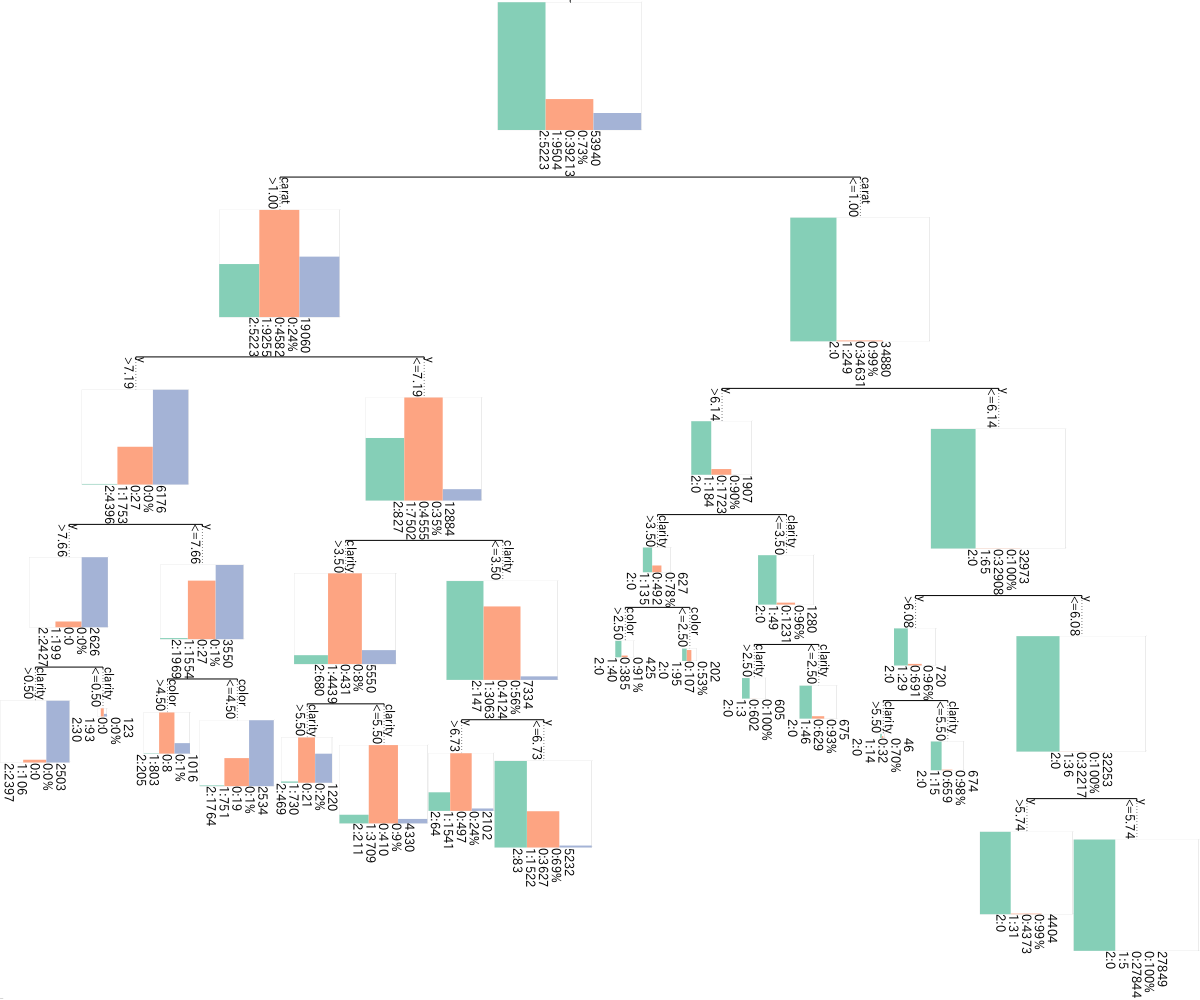

In [14]:
# 説明変数がすべて連続値の場合
obj_unique = np.sort(dfle[coly].unique())
tree = makeTreeEte3CART(clf, colx, obj_unique
                        , le_list_rename=None
                        , dtype_arr=None
                        , fsize=200, height=1000, width=1200, rotation=90, node_face_type='bar'
                        , name='sklearn_CART')  # sklearn_CART.svgが保存される

# Jupyter上に可視化(Jupyter上だとテキストが表示されない場合がある。保存したファイルにはテキストがあるはず。)
ts = TreeStyle()
ts.show_leaf_name = True
ts.rotation = 90
tree.render("%%inline", tree_style=ts, h=1000, w=1200)

可視化した図③ rotation=0   
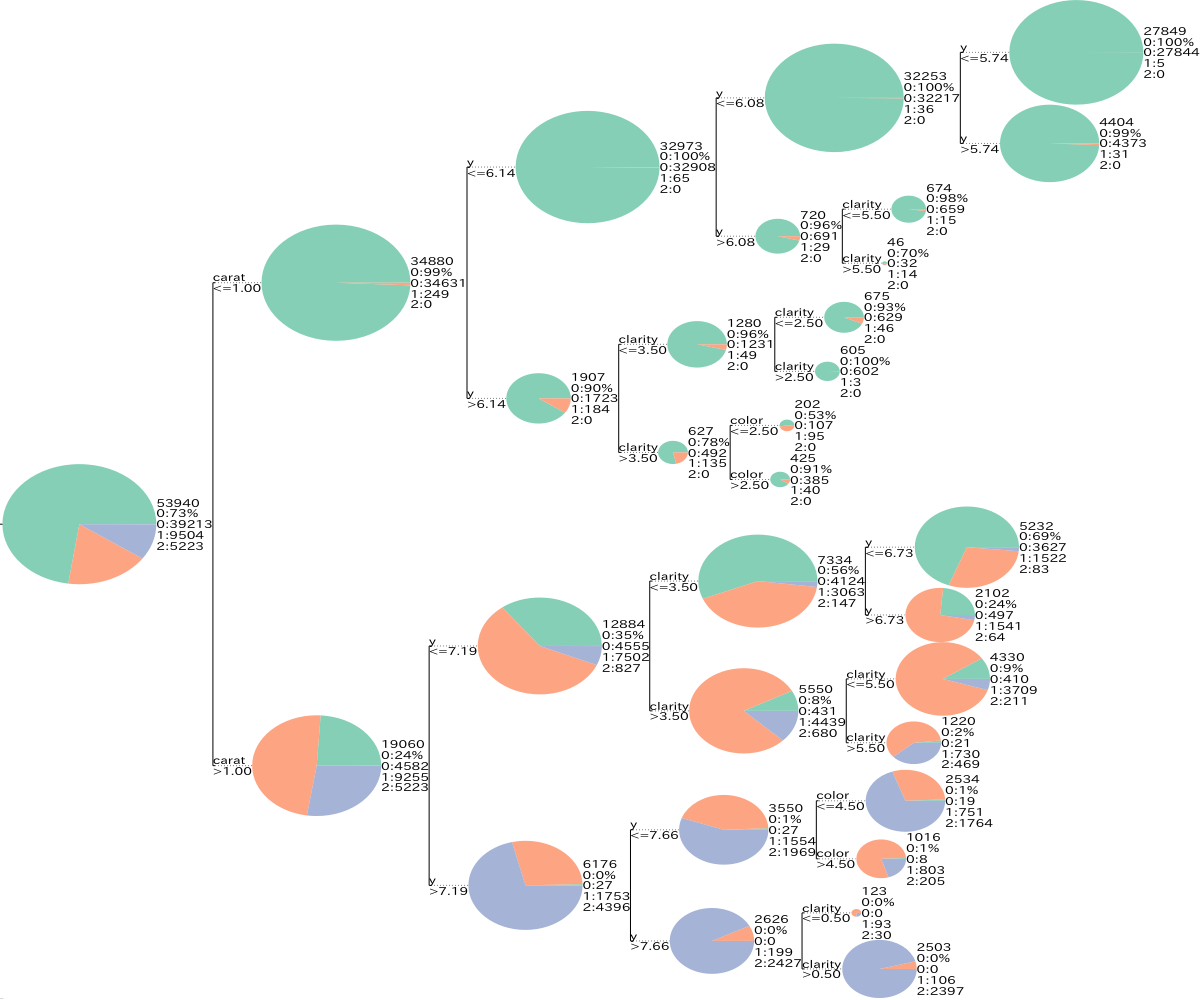

## 説明変数が一部質的データの場合

In [15]:
# 質的データがある時のCART可視化
# 今回は一部のデータが質的データと仮定
df_add = dfle.copy()
# ビニングにより順序尺度データに変換
bin_dict = {}  # 各カラムのビニング後の値とビニング前の数値の幅を辞書化する
dtype_arr = {}  # 各カラムのデータ型指定（'object'=質的データ。その他=連続値。）
category_cols = category_cols
bin_cols = colx[6:]  # 今回はx,y,zのカラムも質的データと仮定
continuous_cols = colx[3:6]  # 残りのカラムが量的データと仮定
for i, col in enumerate(np.concatenate([category_cols,continuous_cols,bin_cols])):
    if col in bin_cols:
        dtype_arr[col] = 'object'
        # 1次元クラスタリングで順序尺度化
        est = KBinsDiscretizer(n_bins=5, strategy="kmeans", encode='ordinal')
        bins_ = est.fit_transform(df_add[col].to_numpy().reshape(-1, 1))
        df_add[col] = bins_
        binmast = pd.DataFrame({'org':df[col].to_numpy(), 'bins':bins_.reshape(-1)})
        binmast_min = binmast.groupby('bins')['org'].min().reset_index()
        binmast_max = binmast.groupby('bins')['org'].max().reset_index()
        binmast = pd.merge(binmast_min, binmast_max, on=['bins'], how='outer', suffixes=['_min','_max'])
        binmast['ranges'] = binmast['org_min'].round(2).astype(str)+'-->'+binmast['org_max'].round(2).astype(str)  # ビン化する前の数値の範囲（例：'11.61-->12.7'）
        bin_dict_val = {row['bins']:row['ranges'] for index, row in binmast.iterrows()}
        bin_dict[col] = bin_dict_val
    else:
        if col in category_cols:
            dtype_arr[col] = 'object'
            bin_dict[col] = ''
        else:
            dtype_arr[col] = 'number'
            bin_dict[col] = ''

print(dtype_arr)
bin_dict.update(le_list)  # ラベルマスタ
print(bin_dict)
display(df_add.head())

{'cut': 'object', 'color': 'object', 'clarity': 'object', 'carat': 'number', 'depth': 'number', 'table': 'number', 'x': 'object', 'y': 'object', 'z': 'object'}
{'cut': {0: 'Fair', 1: 'Good', 2: 'Ideal', 3: 'Premium', 4: 'Very Good'}, 'color': {0: 'D', 1: 'E', 2: 'F', 3: 'G', 4: 'H', 5: 'I', 6: 'J'}, 'clarity': {0: 'I1', 1: 'IF', 2: 'SI1', 3: 'SI2', 4: 'VS1', 5: 'VS2', 6: 'VVS1', 7: 'VVS2'}, 'carat': '', 'depth': '', 'table': '', 'x': {0.0: '0.0-->0.0', 1.0: '3.73-->4.98', 2.0: '4.99-->6.0', 3.0: '6.01-->7.1', 4.0: '7.11-->10.74'}, 'y': {0.0: '0.0-->0.0', 1.0: '3.68-->5.84', 2.0: '5.85-->10.54', 3.0: '31.8-->31.8', 4.0: '58.9-->58.9'}, 'z': {0.0: '0.0-->1.53', 1.0: '2.06-->3.38', 2.0: '3.39-->4.28', 3.0: '4.29-->8.06', 4.0: '31.8-->31.8'}}


/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.


,carat,cut,color,clarity,depth,table,price,x,y,z,target
0,0.23,2,1,3,61.5,55.0,326,1.0,1.0,1.0,0
1,0.21,3,1,2,59.8,61.0,326,1.0,1.0,1.0,0
2,0.23,1,1,4,56.9,65.0,327,1.0,1.0,1.0,0
3,0.29,3,5,5,62.4,58.0,334,1.0,1.0,1.0,0
4,0.31,1,6,3,63.3,58.0,335,1.0,1.0,1.0,0


In [16]:
# 学習
clf = DecisionTreeClassifier(min_samples_split=100, max_depth=4, random_state=0)
clf.fit(df_add[colx].to_numpy(), df_add[coly].to_numpy())

DecisionTreeClassifier(max_depth=4, min_samples_split=100, random_state=0)

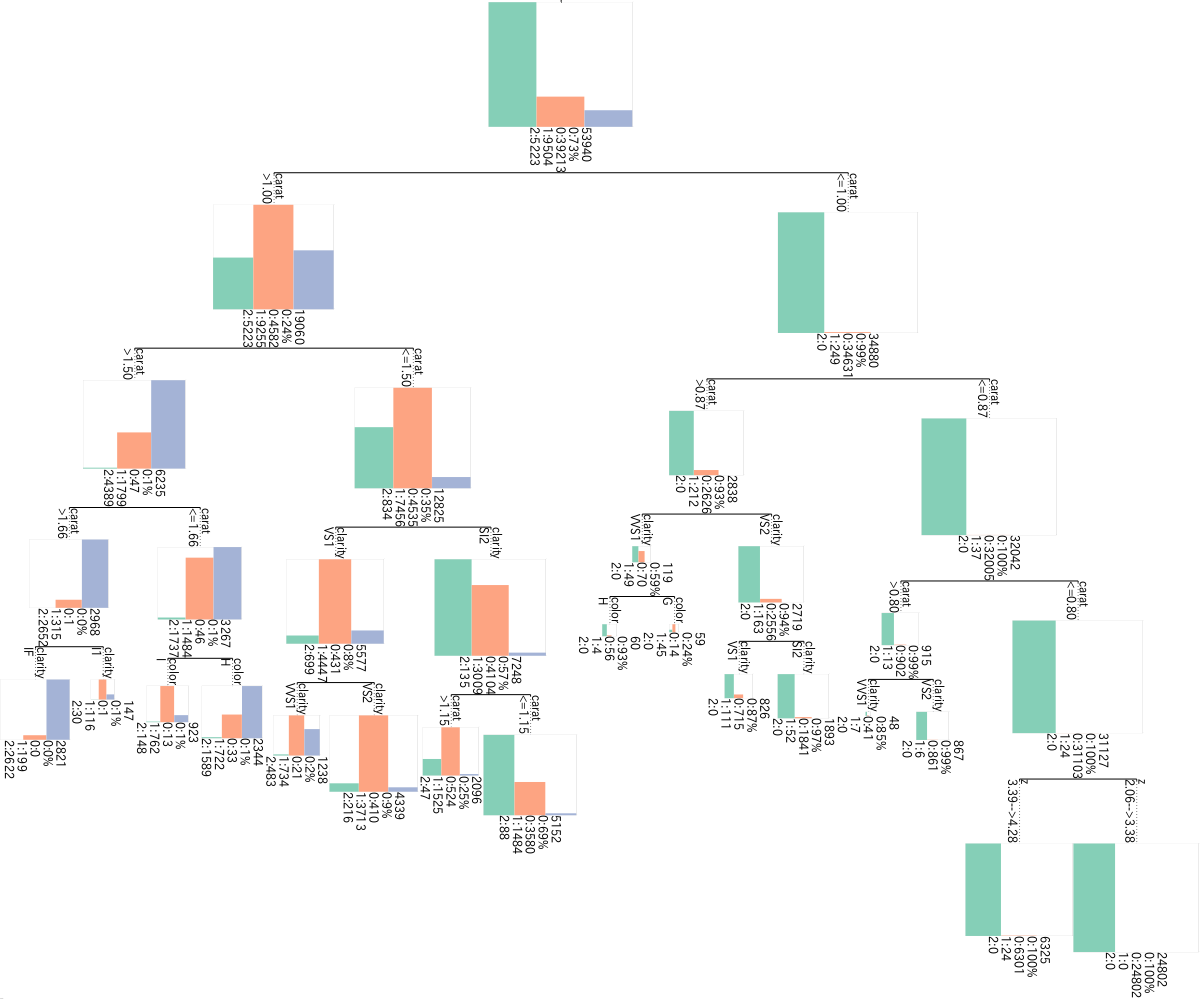

In [17]:
obj_unique = np.sort(df_add[coly].unique())
tree = makeTreeEte3CART(clf, colx, obj_unique
                        , le_list_rename=bin_dict
                        , dtype_arr=dtype_arr
                        , fsize=200, height=1000, width=1200, rotation=90, node_face_type='bar'
                        , name='sklearn_CARTbin')  # sklearn_CARTbin.svgが保存される

# Jupyter上に可視化(Jupyter上だとテキストが表示されない場合がある。保存したファイルにはテキストがあるはず。)
ts = TreeStyle()
ts.show_leaf_name = True
ts.rotation = 90
tree.render("%%inline", tree_style=ts, h=1000, w=1200)

可視化した図④ rotation=90   
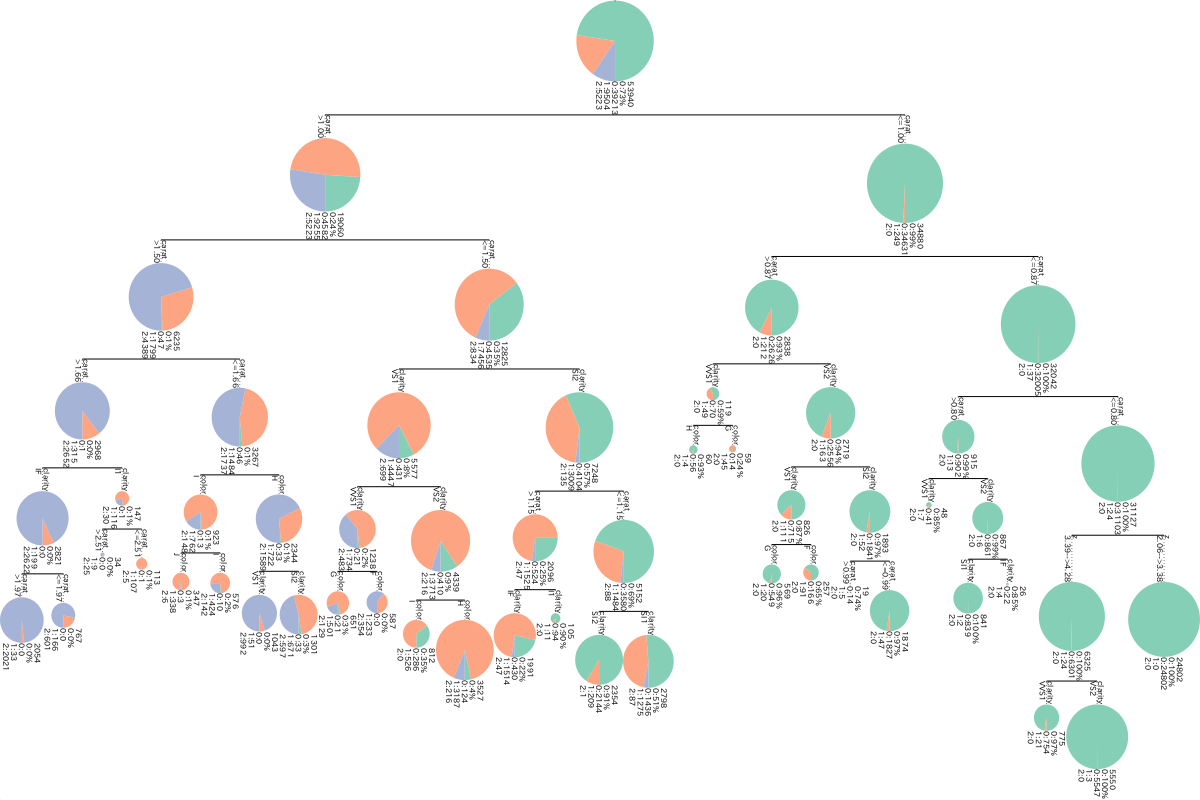

# CHAID

In [21]:
# CHAIDは説明変数が質的データのみ適用可
# すべてのデータを質的データ化する
df_add = dfle.copy()
# ビニングにより順序尺度データに変換
bin_dict = {}  # 各カラムのビニング後の値とビニング前の数値の幅を辞書化する
dtype_arr = {}  # 各カラムのデータ型指定（'object'=質的データ。その他=連続値。）
category_cols = category_cols  # 質的データ
continuous_cols = colx[3:]  # 量的データから質的データへ
for i, col in enumerate(np.concatenate([category_cols,continuous_cols])):
    if col in continuous_cols:
        dtype_arr[col] = 'object'
        # 1次元クラスタリングで順序尺度化
        est = KBinsDiscretizer(n_bins=15, strategy="kmeans", encode='ordinal')
        bins_ = est.fit_transform(df_add[col].to_numpy().reshape(-1, 1))
        df_add[col] = bins_
        binmast = pd.DataFrame({'org':df[col].to_numpy(), 'bins':bins_.reshape(-1)})
        binmast_min = binmast.groupby('bins')['org'].min().reset_index()
        binmast_max = binmast.groupby('bins')['org'].max().reset_index()
        binmast = pd.merge(binmast_min, binmast_max, on=['bins'], how='outer', suffixes=['_min','_max'])
        binmast['ranges'] = binmast['org_min'].round(2).astype(str)+'-->'+binmast['org_max'].round(2).astype(str)  # ビン化する前の数値の範囲（例：'11.61-->12.7'）
        bin_dict_val = {row['bins']:row['ranges'] for index, row in binmast.iterrows()}
        bin_dict[col] = bin_dict_val
    else:
        dtype_arr[col] = 'object'
        bin_dict[col] = ''

print(dtype_arr)
bin_dict.update(le_list)  # ラベルマスタ
print(bin_dict)
display(df_add.head())

/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsampl

{'cut': 'object', 'color': 'object', 'clarity': 'object', 'carat': 'object', 'depth': 'object', 'table': 'object', 'x': 'object', 'y': 'object', 'z': 'object'}
{'cut': {0: 'Fair', 1: 'Good', 2: 'Ideal', 3: 'Premium', 4: 'Very Good'}, 'color': {0: 'D', 1: 'E', 2: 'F', 3: 'G', 4: 'H', 5: 'I', 6: 'J'}, 'clarity': {0: 'I1', 1: 'IF', 2: 'SI1', 3: 'SI2', 4: 'VS1', 5: 'VS2', 6: 'VVS1', 7: 'VVS2'}, 'carat': {0.0: '0.2-->0.48', 1.0: '0.49-->0.8', 2.0: '0.81-->1.09', 3.0: '1.1-->1.38', 4.0: '1.39-->1.78', 5.0: '1.79-->2.11', 6.0: '2.12-->2.35', 7.0: '2.36-->2.72', 8.0: '2.74-->3.11', 9.0: '3.22-->3.4', 10.0: '3.5-->3.67', 11.0: '4.0-->4.01', 12.0: '4.13-->4.13', 13.0: '4.5-->4.5', 14.0: '5.01-->5.01'}, 'depth': {0.0: '43.0-->44.0', 1.0: '50.8-->54.7', 2.0: '55.0-->57.3', 3.0: '57.4-->58.6', 4.0: '58.7-->59.6', 5.0: '59.7-->60.4', 6.0: '60.5-->61.2', 7.0: '61.3-->62.0', 8.0: '62.1-->62.7', 9.0: '62.8-->63.5', 10.0: '63.6-->64.6', 11.0: '64.7-->66.1', 12.0: '66.2-->68.2', 13.0: '68.3-->73.6', 14.0

/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.


,carat,cut,color,clarity,depth,table,price,x,y,z,target
0,0.0,2,1,3,7.0,6.0,326,1.0,1.0,3.0,0
1,0.0,3,1,2,5.0,8.0,326,1.0,1.0,3.0,0
2,0.0,1,1,4,2.0,9.0,327,1.0,1.0,3.0,0
3,0.0,3,5,5,8.0,7.0,334,2.0,1.0,3.0,0
4,0.0,1,6,3,9.0,7.0,335,2.0,1.0,3.0,0


In [22]:
# CHAID可視化関数
def makeTreeEte3CHAID(tree_model, obj_unique, le_list_rename=None, fsize=100, height=300, width=300, diameter=100, rotation=90, node_face_type='pie', name='tmp'):
    # CHAIDパッケージは必須
    try:
        import sklearn2pmml
        import CHAID
    except ModuleNotFoundError:
        import CHAID

    # CHAIDパッケージのオブジェクト
    if type(tree_model)==CHAID.Tree:
        print('CHAID Pakage Model', tree_model)  # おまじない。tree_modelをprintすればOK。しないとtree_model.node_countが0になる。
        tree_n_node_samples = [sum([v for v in tree_model.get_node(i).members.values()]) for i in range(tree_model.node_count)]
        tree_node_count = tree_model.node_count
        tree_value = [np.array([v for v in tree_model.get_node(i).members.values()]) for i in range(tree_model.node_count)]
        tree_value_sum = [sum([v for v in tree_model.get_node(i).members.values()]) for i in range(tree_model.node_count)]
        tree_node_id = [tree_model.get_node(i).node_id for i in range(tree_model.node_count)]
        tree_column = [tree_model.get_node(i).split.column for i in range(tree_model.node_count)]
        tree_groupings = [ast.literal_eval(tree_model.get_node(i).split.groupings) for i in range(tree_model.node_count)]
        tree_children = [tree_model.to_tree().children(i) for i in range(tree_model.node_count)]
    # CHAIDClassifierオブジェクト
    elif type(tree_model)==sklearn2pmml.tree.chaid.CHAIDClassifier:
        print('CHAIDClassifier Model for sklearn2pmml', tree_model)  # おまじない。tree_modelをprintすればOK。しないとtree_model.node_countが0になる。
        tree_n_node_samples = [sum([v for v in model.tree_.get_node(i).members.values()]) for i in range(model.tree_.node_count)]
        tree_node_count = model.tree_.node_count
        tree_value = [np.array([v for v in model.tree_.get_node(i).members.values()]) for i in range(model.tree_.node_count)]
        tree_value_sum = [sum([v for v in model.tree_.get_node(i).members.values()]) for i in range(model.tree_.node_count)]
        tree_node_id = [model.tree_.get_node(i).node_id for i in range(model.tree_.node_count)]
        tree_column = [model.tree_.get_node(i).split.column for i in range(model.tree_.node_count)]
        tree_groupings = [ast.literal_eval(model.tree_.get_node(i).split.groupings) for i in range(model.tree_.node_count)]
        tree_children = [model.tree_.to_tree().children(i) for i in range(model.tree_.node_count)]
    else:
        raise AttributeError('tree_model is incompatible')
            
    # eteのTreeインスタンスを構築
    tree = Tree()
    nodesize={}
    for i, n in enumerate(np.sort(tree_n_node_samples)):
        nodesize[n] = i+1
        
    # 各ノードを設定していく
    # tree_.node_countはノード数を返す
    for i in tqdm(range(tree_node_count)):
        if i == 0:
            tree.name = str(0)
        
        # 設定するノードを指定
        # name=str(i)であるete3親ノードの設定をする
        node = tree.search_nodes(name=str(i))[0]
        # ノードごとに目的変数別の%を計算し、配分の円グラフを作成
        if node_face_type == 'pie':
            Graph_Object = PieChartFace(percents=tree_value[i]/tree_value_sum[i] * 100  # 目的変数別の割合
                                        , width=nodesize[tree_n_node_samples[i]]*diameter  # nodesize辞書内の数値×100
                                        , height=nodesize[tree_n_node_samples[i]]*diameter  # nodesize辞書内の数値×100
                                        , colors=ete3.COLOR_SCHEMES['set2'])# グラフの色
        # ノードごとに目的変数別の数を計算し、barグラフを作成
        elif node_face_type == 'bar':
            Graph_Object = BarChartFace(values=tree_value[i]  # 目的変数別のサンプル数
                                        , width=nodesize[tree_n_node_samples[i]]*diameter  # nodesize辞書内の数値×100
                                        , height=nodesize[tree_n_node_samples[i]]*diameter  # nodesize辞書内の数値×100
                                        , colors=ete3.COLOR_SCHEMES['set2'])# グラフの色
        else:
            print('Node face type is selected as `PieChartFace`')
            Graph_Object = PieChartFace(percents=tree_value[i]/tree_value_sum[i] * 100  # 目的変数別の割合
                                        , width=nodesize[tree_n_node_samples[i]]*diameter  # nodesize辞書内の数値×100
                                        , height=nodesize[tree_n_node_samples[i]]*diameter  # nodesize辞書内の数値×100
                                        , colors=ete3.COLOR_SCHEMES['set2'])# グラフの色
        Graph_Object.rotation = 360 - rotation  # rotation度回転
        Graph_Object.opacity = 0.8
        
        node.add_face(Graph_Object, column=2, position="branch-right")
        if len(tree_children[i]) > 0:
            for chi in range(len(tree_children[i])):
                # 子ノードid
                child_id = tree_children[i][chi].identifier
                node.add_child(name=str(child_id))  # ete3子ノード追加
                # 対象を子ノードに移す
                node = tree.search_nodes(name=str(child_id))[0]
                # 分岐条件を追加
                # position='aligned', 'branch-top', 'float-behind', 'branch-bottom', 'float', 'branch-right'
                node.add_face(TextFace(tree_column[i], fsize=fsize)  # 特徴量の名前
                              , column=0, position="branch-top")  # Text位置
                if le_list_rename:
                    replace_val = le_list_rename[tree_column[i]]
                    node.add_face(TextFace(str([replace_val[st] for st in tree_groupings[i][chi]]), fsize=fsize)  # 特徴量の分岐の閾値
                                  , column=1, position="branch-bottom")  # Text位置
                else:
                    node.add_face(TextFace(tree_groupings[i][chi], fsize=fsize)  # 特徴量の分岐の閾値
                                  , column=1, position="branch-bottom")  # Text位置
                # 親ノードに対象を戻しておく
                node = tree.search_nodes(name=str(i))[0]
        
        # ノード内のサンプル数や割合をテキストとして記す
        obj_unique = sorted(obj_unique)
        text1 = str(obj_unique[0])+":{0:.0f}".format(tree_value[i][0]/tree_value_sum[i] * 100) + "%"
        text1_1 = "{0:.0f}".format(tree_n_node_samples[i])
        texts_ary = []
        for obj_i, obj_val in enumerate(obj_unique):# 各クラスのサンプル数
            txt = "{:.0f}:{:.0f}".format(obj_i, tree_value[i][obj_i])
            texts_ary.append(txt)
        
        # 情報を書き込み
        # position='aligned', 'branch-top', 'float-behind', 'branch-bottom', 'float', 'branch-right'
        node.add_face(TextFace(text1_1, fsize=fsize, fgcolor="black")
                      , column=4, position="branch-right")
        node.add_face(TextFace(text1, fsize=fsize, fgcolor="black")
                      , column=4, position="branch-right")
        for txt_i in texts_ary:
            node.add_face(TextFace(txt_i, fsize=fsize)
                          , column=4, position="branch-right")

    # 図の回転
    ts = TreeStyle()
    ts.show_leaf_name = True
    ts.rotation = rotation
    # 図の保存
    tree.render(name+'.svg', h=height, w=width, tree_style=ts, dpi=250)
    try:
        from svglib.svglib import svg2rlg
        from reportlab.graphics import renderPDF, renderPM
        import rlPyCairo
        import sys
        filename = name+'.svg'
        drawing = svg2rlg(filename)
        renderPDF.drawToFile(drawing, filename + ".pdf")
        drawing = svg2rlg(filename)
        renderPM.drawToFile(drawing, filename + ".png", fmt="PNG", dpi=250)
    except ModuleNotFoundError:
        pass
    return tree

CHAID Pakage Model [([], {0: 39213.0, 1: 9504.0, 2: 5223.0}, (x, p=0.0, score=59132.67348425472, groups=[[0.0], [1.0], [2.0], [3.0], [4.0], [5.0], [6.0], [7.0], [8.0], [9.0], [10.0], [11.0], [12.0], [13.0], [14.0]]), dof=28)), ([0.0], {0: 3.0, 1: 2.0, 2: 3.0}, <Invalid Chaid Split> - the minimum parent node size threshold has been reached), ([1.0], {0: 1273.0, 1: 0, 2: 0}, <Invalid Chaid Split> - the node only contains single category respondents), ([2.0], {0: 6489.0, 1: 0, 2: 0}, <Invalid Chaid Split> - the node only contains single category respondents), ([3.0], {0: 4278.0, 1: 0, 2: 0}, <Invalid Chaid Split> - the node only contains single category respondents), ([4.0], {0: 5538.0, 1: 0, 2: 0}, <Invalid Chaid Split> - the node only contains single category respondents), ([5.0], {0: 7044.0, 1: 1.0, 2: 0}, (clarity, p=2.2248276257544844e-06, score=36.478582194594466, groups=[[0.0, 2.0], [1.0], [3.0], [4.0], [5.0], [6.0], [7.0]]), dof=6)), ([0.0, 2.0], {0: 1708.0, 1: 0, 2: 0}, <Invalid 

100%|███████████████████████████████████████████████████████████████████████████████| 185/185 [00:00<00:00, 3180.36it/s]


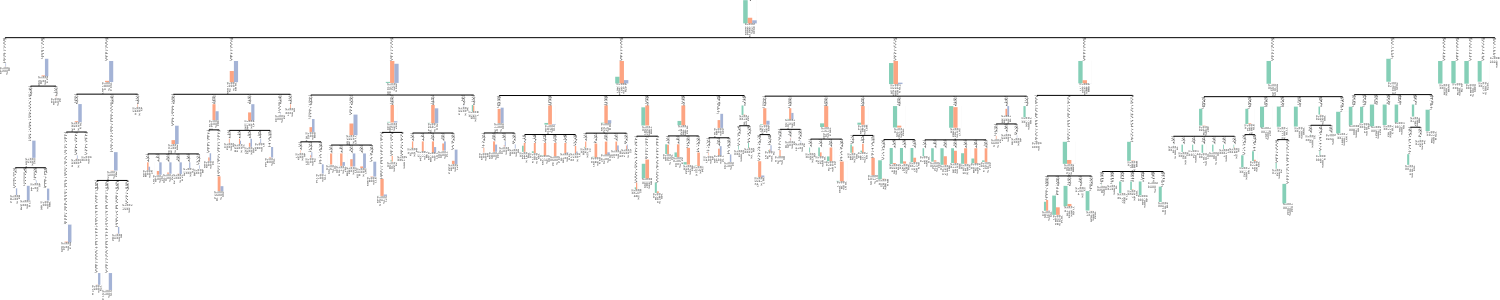

In [33]:
# CHAIDパッケージによりモデル構築
types_dic = dict(zip(colx[3:], ['ordinal'] * len(colx[3:])))  # 一部の変数が順序尺度と指定
types_dic2 = dict(zip(colx[:3], ['nominal'] * len(colx[:3])))  # 一部の変数が順序尺度と指定
types_dic.update(types_dic2)  # dfのカラムの順番と揃えておく必要はある？一応揃えてはいる。
# print(types_dic)
# モデル構築
tree_model2 = chaidTree.from_pandas_df(df_add, types_dic, coly, max_depth=3)
obj_unique = np.sort(df_add[coly].unique())
tree = makeTreeEte3CHAID(tree_model2, obj_unique, le_list_rename=bin_dict
                         , fsize=1000, height=300, width=1500
                         , diameter=50, rotation=90, node_face_type='bar'
                         , name='CHAIDpackage_CHAID')  # CHAIDpackage_CHAID.svgが保存される
# Jupyter上に可視化(Jupyter上だとテキストが表示されない場合がある。保存したファイルにはテキストがあるはず。)
ts = TreeStyle()
ts.show_leaf_name = True
ts.rotation = 90
tree.render("%%inline", tree_style=ts, h=300, w=1500, dpi=250)

可視化した図⑤ rotation=90  
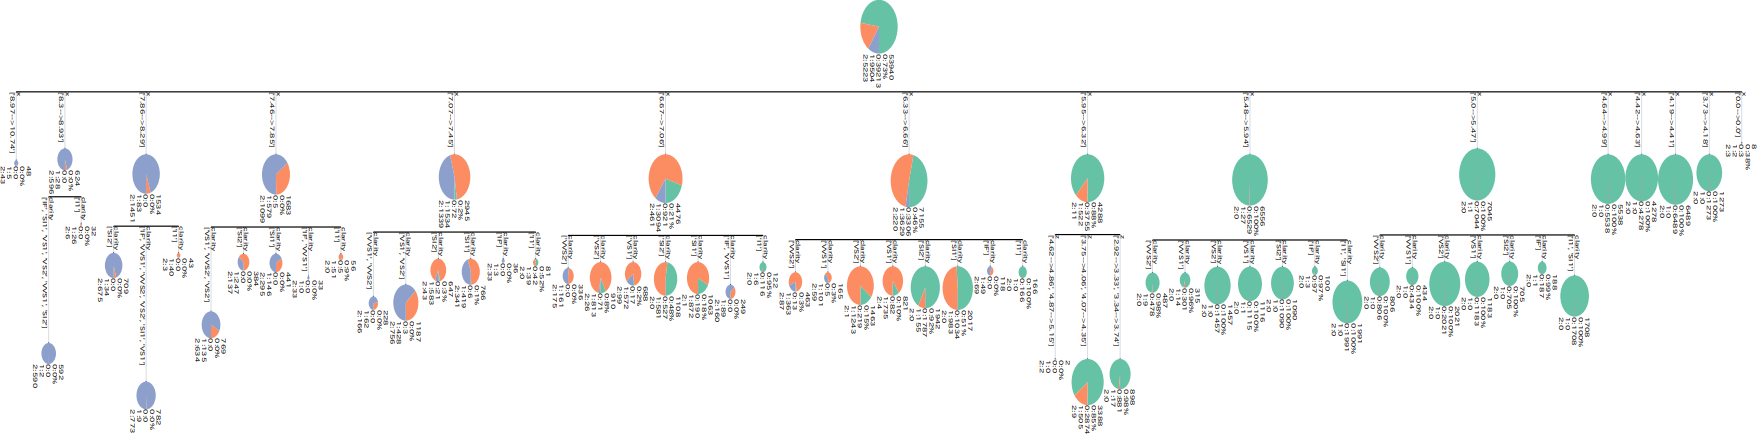

CHAIDClassifier Model for sklearn2pmml CHAIDClassifier(config={'max_depth': 3})


100%|███████████████████████████████████████████████████████████████████████████████| 204/204 [00:00<00:00, 2381.05it/s]


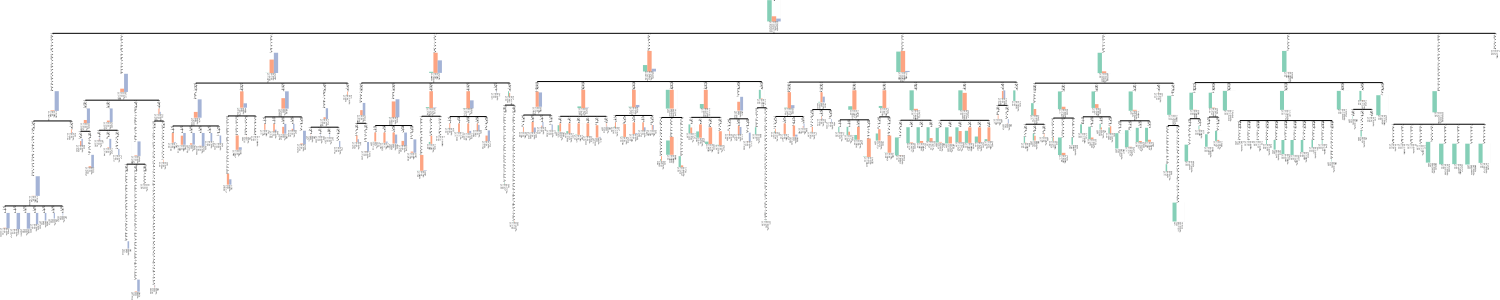

In [37]:
# sklearn2pmml パッケージのCHAIDClassifierによりモデル構築
# このCHAIDのwrapperでは順序尺度を選択できない（名義尺度のみ）
config = {"max_depth" : 3}
model = CHAIDClassifier(config = config)
model.fit(df_add[colx], df_add[coly])
obj_unique = np.sort(df_add[coly].unique())
tree = makeTreeEte3CHAID(model, obj_unique, le_list_rename=bin_dict
                         , fsize=1000, height=300, width=1500
                         , diameter=50, rotation=90, node_face_type='bar'
                         , name='CHAIDClassifier_CHAID')  # CHAIDClassifier_CHAID.svgが保存される
# Jupyter上に可視化(Jupyter上だとテキストが表示されない場合がある。保存したファイルにはテキストがあるはず。)
ts = TreeStyle()
ts.show_leaf_name = True
ts.rotation = 90
tree.render("%%inline", tree_style=ts, h=300, w=1500)

可視化した図⑥  rotation=90  
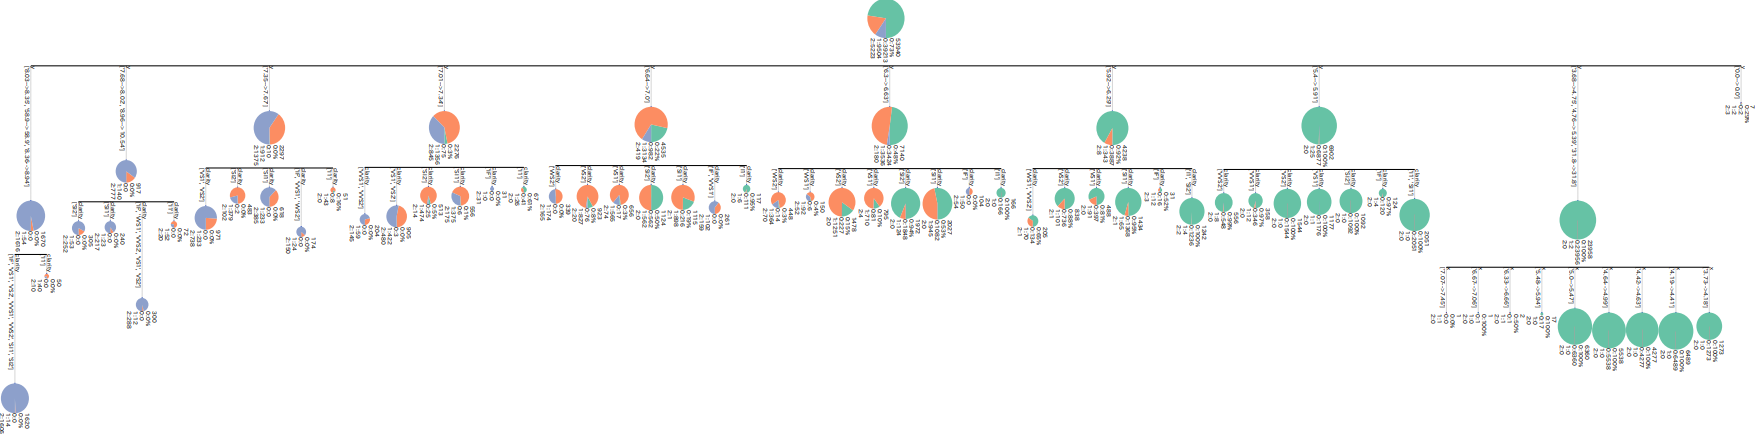

# RのCHAID

In [156]:
# CHAIDは説明変数が質的データのみ適用可
# すべてのデータを質的データ化する
df_add = dfle.copy()
# ビニングにより順序尺度データに変換
bin_dict = {}  # 各カラムのビニング後の値とビニング前の数値の幅を辞書化する
dtype_arr = {}  # 各カラムのデータ型指定（'object'=質的データ。その他=連続値。）
category_cols = category_cols  # 質的データ
continuous_cols = colx[3:]  # 量的データから質的データへ
for i, col in enumerate(np.concatenate([category_cols,continuous_cols])):
    if col in continuous_cols:
        dtype_arr[col] = 'object'
        # 1次元クラスタリングで順序尺度化
        est = KBinsDiscretizer(n_bins=15, strategy="kmeans", encode='ordinal')
        bins_ = est.fit_transform(df_add[col].to_numpy().reshape(-1, 1))
        df_add[col] = bins_
        binmast = pd.DataFrame({'org':df[col].to_numpy(), 'bins':bins_.reshape(-1)})
        binmast_min = binmast.groupby('bins')['org'].min().reset_index()
        binmast_max = binmast.groupby('bins')['org'].max().reset_index()
        binmast = pd.merge(binmast_min, binmast_max, on=['bins'], how='outer', suffixes=['_min','_max'])
        binmast['ranges'] = binmast['org_min'].round(2).astype(str)+'-->'+binmast['org_max'].round(2).astype(str)  # ビン化する前の数値の範囲（例：'11.61-->12.7'）
        bin_dict_val = {row['bins']:row['ranges'] for index, row in binmast.iterrows()}
        bin_dict[col] = bin_dict_val
    else:
        dtype_arr[col] = 'object'
        bin_dict[col] = ''

print(dtype_arr)
bin_dict.update(le_list)  # ラベルマスタ
print(bin_dict)
display(df_add.head())

/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsampl

{'cut': 'object', 'color': 'object', 'clarity': 'object', 'carat': 'object', 'depth': 'object', 'table': 'object', 'x': 'object', 'y': 'object', 'z': 'object'}
{'cut': {0: 'Fair', 1: 'Good', 2: 'Ideal', 3: 'Premium', 4: 'Very Good'}, 'color': {0: 'D', 1: 'E', 2: 'F', 3: 'G', 4: 'H', 5: 'I', 6: 'J'}, 'clarity': {0: 'I1', 1: 'IF', 2: 'SI1', 3: 'SI2', 4: 'VS1', 5: 'VS2', 6: 'VVS1', 7: 'VVS2'}, 'carat': {0.0: '0.2-->0.48', 1.0: '0.49-->0.8', 2.0: '0.81-->1.09', 3.0: '1.1-->1.38', 4.0: '1.39-->1.78', 5.0: '1.79-->2.11', 6.0: '2.12-->2.35', 7.0: '2.36-->2.72', 8.0: '2.74-->3.11', 9.0: '3.22-->3.4', 10.0: '3.5-->3.67', 11.0: '4.0-->4.01', 12.0: '4.13-->4.13', 13.0: '4.5-->4.5', 14.0: '5.01-->5.01'}, 'depth': {0.0: '43.0-->44.0', 1.0: '50.8-->54.7', 2.0: '55.0-->57.3', 3.0: '57.4-->58.6', 4.0: '58.7-->59.6', 5.0: '59.7-->60.4', 6.0: '60.5-->61.2', 7.0: '61.3-->62.0', 8.0: '62.1-->62.7', 9.0: '62.8-->63.5', 10.0: '63.6-->64.6', 11.0: '64.7-->66.1', 12.0: '66.2-->68.2', 13.0: '68.3-->73.6', 14.0

/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.


,carat,cut,color,clarity,depth,table,price,x,y,z,target
0,0.0,2,1,3,7.0,6.0,326,1.0,1.0,3.0,0
1,0.0,3,1,2,5.0,8.0,326,1.0,1.0,3.0,0
2,0.0,1,1,4,2.0,9.0,327,1.0,1.0,3.0,0
3,0.0,3,5,5,8.0,7.0,334,2.0,1.0,3.0,0
4,0.0,1,6,3,9.0,7.0,335,2.0,1.0,3.0,0


In [157]:
import rpy2
from rpy2 import robjects  # Rを起動
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [158]:
# %R install.packages('tidyverse')
# %R install.packages("CHAID", repos="http://R-Forge.R-project.org")
# %R install.packages('caret')
# %R install.packages('doParallel')

In [159]:
%%R
library('tidyverse')
library('CHAID')
library('caret')
library('doParallel')

In [160]:
# Python側のデータを持ってくる
%R -i df_add
%R -i colx
%R -i coly
%R print(colx)
%R print(coly)

[1] "cut"     "color"   "clarity" "carat"   "depth"   "table"   "x"      
[8] "y"       "z"      
[1] "target"


array(['target'], dtype='<U6')

In [161]:
%%R
# factor型に変更
df_add_f <- df_add %>% mutate(across(everything(), as.factor))
# NaNを除外
# df_add_f <- na.omit(df_add_f)
print(nrow(df_add_f))
print(ncol(df_add_f))
head(df_add_f)

[1] 53940
[1] 11
  carat cut color clarity depth table price x y z target
0     0   2     1       3     7     6   326 1 1 3      0
1     0   3     1       2     5     8   326 1 1 3      0
2     0   1     1       4     2     9   327 1 1 3      0
3     0   3     5       5     8     7   334 2 1 3      0
4     0   1     6       3     9     7   335 2 1 3      0
5     0   4     6       7     9     7   336 1 1 3      0


In [162]:
# 使用コア数
%R cl <- makePSOCKcluster(16)
%R registerDoParallel(cl)

<rpy2.robjects.functions.SignatureTranslatedFunction object at 0x7efbc4090080> [RTYPES.CLOSXP]
R classes: ('function',)

In [187]:
%R cols <- c(colx,coly)
%R df_add_f[, cols]

,cut,color,clarity,carat,depth,table,x,y,z,target
0,2,1,3,0,7,6,1,1,3,0
1,3,1,2,0,5,8,1,1,3,0
2,1,1,4,0,2,9,1,1,3,0
3,3,5,5,0,8,7,2,1,3,0
4,1,6,3,0,9,7,2,1,3,0
...,...,...,...,...,...,...,...,...,...,...
53935,2,0,2,1,6,7,6,3,5,0
53936,1,0,2,1,9,6,6,3,5,0
53937,4,0,2,1,9,8,6,3,5,0
53938,3,4,3,2,6,7,7,4,5,0


In [192]:
%%R
# CHAIDモデルの構築
# alpha2: カテゴリーをマージするかどうかを決定するために使用されるp値の閾値。この値を小さくするとマージが起こりにくくなり、より多くのカテゴリーが残る。デフォルト値は0.05
# alpha3: 分割後のノードでカテゴリーをマージするかどうかを決定するために使用されるp値の閾値。デフォルト値は-1（使用しない）
# alpha4: ノードを分割するかどうかを決定するために使用されるp値の閾値。この値を小さくすると分割が起こりにくくなり、より小さな木になる。デフォルト値は0.05
# minprob: 親ノードに対する子ノードのサイズの最小割合を指定する。この値を大きくすると、小さな子ノードが生成されにくくなり、より小さな木になる。デフォルト値は0.01
# minsplit: 分割の最小サイズ。ノードを分割するために必要な最小のレコード数を指定する。この値を大きくすると、小さなノードが生成されにくくなり、より小さな木になる。デフォルト値は20
# minbucket: 末端ノードの最小サイズ。末端ノード（葉ノード）に含まれるべき最小のレコード数を指定する。この値を大きくすると、小さな末端ノードが生成されにくくなり、より小さな木になる。デフォルト値は7

chaid_model <- chaid(target ~ .,
                     data = df_add_f[, cols],
                     control = chaid_control(alpha2=0.01, alpha3=-1, alpha4=0.1, maxheight=2, minprob = 0.01, minsplit = 100, minbucket = 100)
                    )


# PDFとして保存
pdf( "R_CHAID.pdf", width = 20, height = 10 )
plot(chaid_model
     , gp = gpar(lty = "solid", lwd = 1, fontsize = 6, cex.node = 1., shape = "ellipse")
     , type = "simple"
     )
dev.off()

png 
  2 


可視化した図⑦  
RのChaid  
Rの第1分岐は変数yで9個に分かれる --> [0,1,2,13],[3],[4],[5],[6],[7],[8,12],[9],[10,11,14]  
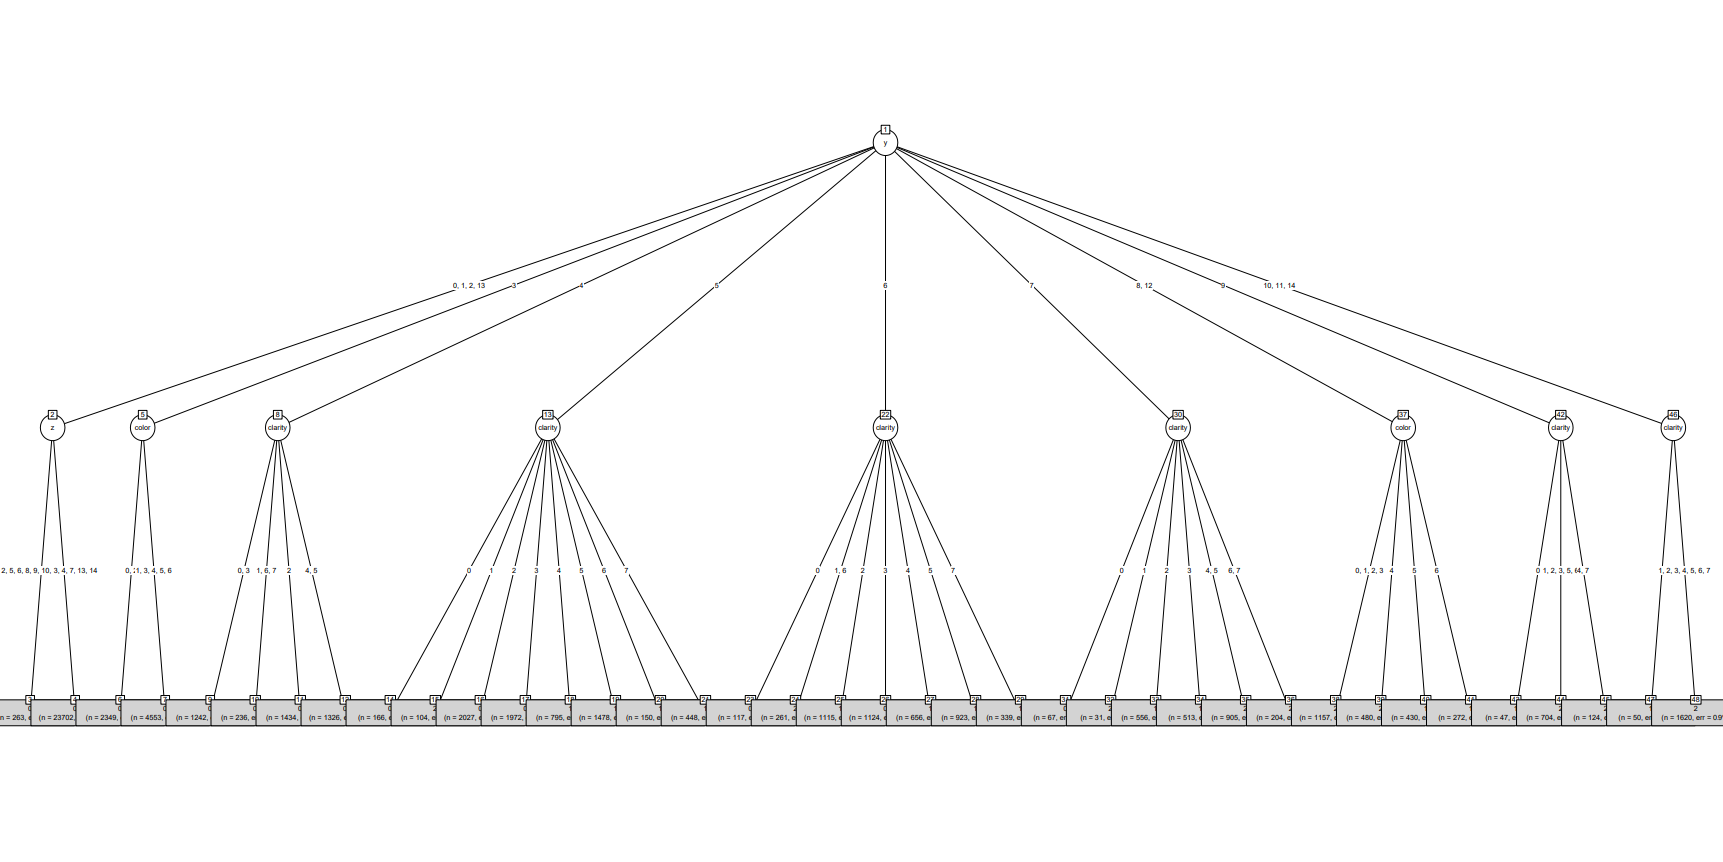  
[比較]PythonのChaidとおおよそ同じ（すべて名義尺度のChaid）  
Pythonの第1分岐は変数yで10個に分かれる --> [0],[1,2,13],[3],[4],[5],[6],[7],[8],[9,12],[10,11,14]  
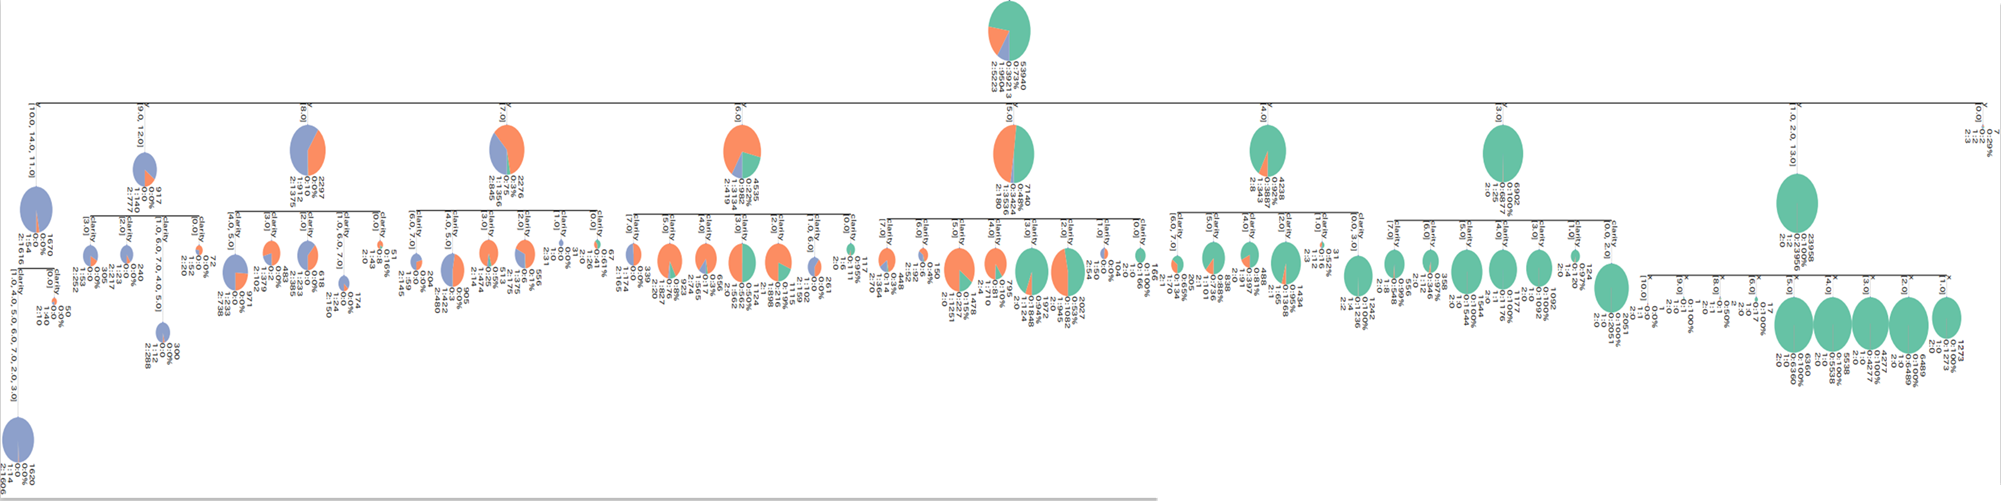